# Description

In [1]:
# TODO(Paul): consider merging (or factoring out common code) with the `Master_research_backtest_analyzer` and `Master_execution_analysis`.

The notebook:
   - Loads results of a historical simulation
   - Computes research portfolio
   - Saves trades and pnl to a file
   - Performs prices and pnl cross-checks

The code overlaps with that from:
   - the `dataflow/model/notebooks/Master_research_backtest_analyzer.ipynb`: load tiled simulation, compute research pnl
   - the `oms/notebooks/Master_execution_analysis.ipynb`: load and resmaple OHLCV prices

What is really unique in the current notebook is:
   - Converting `holdings_shares` to `target_holdings_shares`
   - Saving data to a file
   - Prices and pnl cross-checks

# Imports

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import datetime
import logging
import os

import pandas as pd

import core.config as cconfig
import core.finance.portfolio_df_processing as cfpdp
import core.plotting as coplotti
import dataflow.model as dtfmod
import dataflow_amp.system.Cx as dtfamsysc
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hio as hio
import helpers.hparquet as hparque
import helpers.hprint as hprint
import im_v2.common.universe as ivcu

# TODO(Grisha): probably `dataflow/model` should not depend on `oms`.
import oms.broker.ccxt.ccxt_utils as obccccut

/app/amp/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-251b35d6-e459-44d4-86e2-8a1920eb1f3b.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.10.0' != container_version='1.12.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask6334_update_alpha_eval_package'
  hash='03241255b'
  # Last commits:
    * 03241255b PomazkinG checkpoint                                                        (13 minutes ago) Wed Dec 6 16:36:59 2023  (HEAD -> CmTask6334_update_alpha_eval_package, origin/CmTask6334_update_alpha_eval_package)
    * 6c7f6da9f PomazkinG checkpoint                                                        (13 minutes ago) Wed Dec 6 16:36:

# Build the config

In [5]:
market_info = obccccut.load_market_data_info()
asset_id_to_share_decimals = obccccut.subset_market_info(
    market_info, "amount_precision"
)
asset_id_to_share_decimals

{6051632686: 0,
 8717633868: 0,
 2540896331: 0,
 1528092593: 0,
 8968126878: 2,
 1467591036: 3,
 2476706208: 1,
 5115052901: 0,
 3065029174: 0,
 1891737434: 1,
 3401245610: 1,
 1464553467: 3,
 1966583502: 0,
 1030828978: 0,
 2601760471: 2,
 2683705052: 0,
 9872743573: 0,
 2484635488: 0,
 2099673105: 0,
 4516629366: 0,
 2237530510: 0,
 2425308589: 0,
 1776791608: 1,
 2384892553: 1,
 5118394986: 1}

In [35]:
config = {
    "dir_name": "/shared_data/model/historical/build_tile_configs.C5b.ccxt_v7_1-all.5T.2022-10-01_2023-10-18.ins.run0/tiled_results",
    "start_date": datetime.date(2022, 10, 1),
    "end_date": datetime.date(2023, 10, 18),
    "asset_id_col": "asset_id",
    "pnl_resampling_frequency": "D",
    "universe_version": "v7.1",
    "save_data_dst_dir": "/shared_data/marketing/cmtask6334",
    "annotate_forecasts_kwargs": {
        "burn_in_bars": 3,
        "style": "longitudinal",
        # Apply asset-specific rounding.
        "quantization": None,
        "target_dollar_risk_per_name": 50.0,
        "liquidate_at_end_of_day": False,
        "initialize_beginning_of_day_trades_to_zero": False,
        "asset_id_to_share_decimals": asset_id_to_share_decimals,
    },
    # TODO(Grisha): consider inferring column names from a `DagBuilder` object.
    "column_names": {
        "price_col": "vwap",
        "volatility_col": "garman_klass_vol",
        "prediction_col": "feature",
    },
    "save_data": False,
}
config = cconfig.Config().from_dict(config)
print(config)

dir_name: /shared_data/model/historical/build_tile_configs.C5b.ccxt_v7_1-all.5T.2022-10-01_2023-10-18.ins.run0/tiled_results
start_date: 2022-10-01
end_date: 2023-10-18
asset_id_col: asset_id
pnl_resampling_frequency: D
universe_version: v7.1
save_data_dst_dir: /shared_data/marketing/cmtask6334
annotate_forecasts_kwargs: 
  burn_in_bars: 3
  style: longitudinal
  quantization: None
  target_dollar_risk_per_name: 50.0
  liquidate_at_end_of_day: False
  initialize_beginning_of_day_trades_to_zero: False
  asset_id_to_share_decimals: 
    6051632686: 0
    8717633868: 0
    2540896331: 0
    1528092593: 0
    8968126878: 2
    1467591036: 3
    2476706208: 1
    5115052901: 0
    3065029174: 0
    1891737434: 1
    3401245610: 1
    1464553467: 3
    1966583502: 0
    1030828978: 0
    2601760471: 2
    2683705052: 0
    9872743573: 0
    2484635488: 0
    2099673105: 0
    4516629366: 0
    2237530510: 0
    2425308589: 0
    1776791608: 1
    2384892553: 1
    5118394986: 1
column_names:

# Load tiled results

## Report tile stats

In [7]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    config["dir_name"]
)

In [8]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1030828978,2,12,13,14.2 MB
1464553467,2,12,13,16.5 MB
1467591036,2,12,13,16.7 MB
1528092593,2,12,13,13.2 MB
1776791608,2,12,13,14.9 MB
1891737434,2,12,13,14.3 MB
1966583502,2,12,13,14.1 MB
2099673105,2,12,13,12.5 MB
2237530510,2,12,13,15.9 MB


In [9]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

n_asset_ids     size
year month                      
2022 10              25  28.9 MB
     11              25  29.7 MB
     12              25  29.0 MB
2023 1               25  30.9 MB
     2               25  27.6 MB
     3               25  30.5 MB
     4               25  28.9 MB
     5               25  28.7 MB
     6               25  28.6 MB
     7               25  28.9 MB
     8               25  28.6 MB
     9               25  27.0 MB
     10              25  15.8 MB

In [10]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1030828978,
 1464553467,
 1467591036,
 1528092593,
 1776791608,
 1891737434,
 1966583502,
 2099673105,
 2237530510,
 2384892553,
 2425308589,
 2476706208,
 2484635488,
 2540896331,
 2601760471,
 2683705052,
 3065029174,
 3401245610,
 4516629366,
 5115052901,
 5118394986,
 6051632686,
 8717633868,
 8968126878,
 9872743573]

## Load a single-asset tile

In [11]:
asset_batch_size = 1
cols = None
single_asset_tile = next(
    hparque.yield_parquet_tiles_by_assets(
        config["dir_name"],
        asset_ids[0:1],
        config["asset_id_col"],
        asset_batch_size,
        cols,
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
single_tile_df = dtfmod.process_parquet_read_df(
    single_asset_tile, config["asset_id_col"]
)

In [13]:
single_tile_df.columns.levels[0]

Index(['close', 'close.ret_0', 'close_vol', 'feature', 'feature_raw', 'feature_raw.c', 'garman_klass_vol', 'high', 'low', 'month', 'open', 'parkinson_vol', 'twap', 'twap.ret_0', 'volume', 'vwap', 'vwap.ret_0', 'vwap.ret_0.vol_adj', 'vwap.ret_0.vol_adj.c', 'year'], dtype='object')

In [14]:
single_tile_df.head(3)

,close,close.ret_0,close_vol,feature,feature_raw,feature_raw.c,garman_klass_vol,high,low,month,open,parkinson_vol,twap,twap.ret_0,volume,vwap,vwap.ret_0,vwap.ret_0.vol_adj,vwap.ret_0.vol_adj.c,year
asset_id,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978
end_ts,,,,,,,,,,,,,,,,,,,,
2022-10-01 00:00:00+00:00,0.6408,0.002344,0.002344,-1.301127,1.350170,1.301127,0.001512,0.6408,0.6389,10,0.6393,0.001783,0.64014,0.001689,603628.0,0.639981,0.001253,1.149705,1.119057,2022
2022-10-01 00:05:00+00:00,0.6412,0.000624,0.000624,-1.420240,1.484887,1.420240,0.001266,0.6413,0.6401,10,0.6408,0.001125,0.64056,0.000656,590347.0,0.640698,0.001119,1.126416,1.097556,2022
2022-10-01 00:10:00+00:00,0.6414,0.000312,0.000312,0.479847,-0.482168,-0.479847,0.001530,0.6424,0.6410,10,0.6412,0.001310,0.64160,0.001622,652639.0,0.641417,0.001121,0.741474,0.733096,2022


# Compute portfolio bar metrics

In [15]:
portfolio_df, bar_metrics = dtfmod.annotate_forecasts_by_tile(
    config["dir_name"],
    config["start_date"],
    config["end_date"],
    config["asset_id_col"],
    config["column_names"]["price_col"],
    config["column_names"]["volatility_col"],
    config["column_names"]["prediction_col"],
    annotate_forecasts_kwargs=config["annotate_forecasts_kwargs"].to_dict(),
)

  0%|          | 0/2 [00:00<?, ?it/s]

INFO  spread is `None`; imputing spread_lower_bound=0.000100
INFO  spread is `None`; imputing spread_lower_bound=0.000100


In [16]:
portfolio_df.tail(3)

price                                                                                                                                                                                                                                                                               volatility                                                                                                                                                                                                                                                                         prediction                                                                                                                                                                                                                                                                         holdings_shares                                                                                                                           \
asset_id                  1030828978   1464553467    1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573      1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208   
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2023-10-17 23:50:00+00:00   0.142644  1562.176718  28383.581679   0.132909   6.109897   3.668218   0.177244   1.534217  23.929430   1.471413   0.381433   0.432000   0.115140   4.215317   7.325665   0.518564   0.059002   1.819909   0.286934   0.414609   0.491130   1.089100   9.105905  211.551733   1.007414   0.001490   0.001125   0.000756   0.002585   0.001537   0.000693   0.000969   0.001120   0.001317   0.000977   0.001513   0.003274   0.000879   0.001006   0.000867   0.000782   0.000861   0.001912   0.000741   0.000613   0.000137   0.001578   0.000944   0.000663   0.002109   0.466250   0.097784   0.364693   1.754959  -0.359545   0.313489   1.876125  -0.410708  -0.361124  -0.748767   0.328075   1.130995  -0.277740  -0.595608  -0.368737  -1.081506  -0.015550  -0.402728  -0.530135  -0.571743  -1.210923  -1.051234  -0.245845  -0.179245   1.748617        353546.0     65.031      3.442   707245.0    11756.7   -35351.6   353715.0   -11666.0     1522.0   -47658.7   101823.0    35352.9   
2023-10-17 23:55:00+00:00   0.142701  1563.

In [17]:
bar_metrics.tail(3)

,pnl,gross_volume,net_volume,gmv,nmv
end_ts,,,,,
2023-10-17 23:50:00+00:00,1176.665165,2.588448e+06,465749.385220,1.906687e+06,-57169.829888
2023-10-17 23:55:00+00:00,68.157958,1.960479e+06,-735866.857054,1.511754e+06,-792968.528985
2023-10-18 00:00:00+00:00,42.991019,2.782278e+06,256139.528428,2.633071e+06,-536786.009538


In [18]:
_LOG.info("Mean GMV=%s", bar_metrics["gmv"].mean())

INFO  Mean GMV=1170914.6132950515


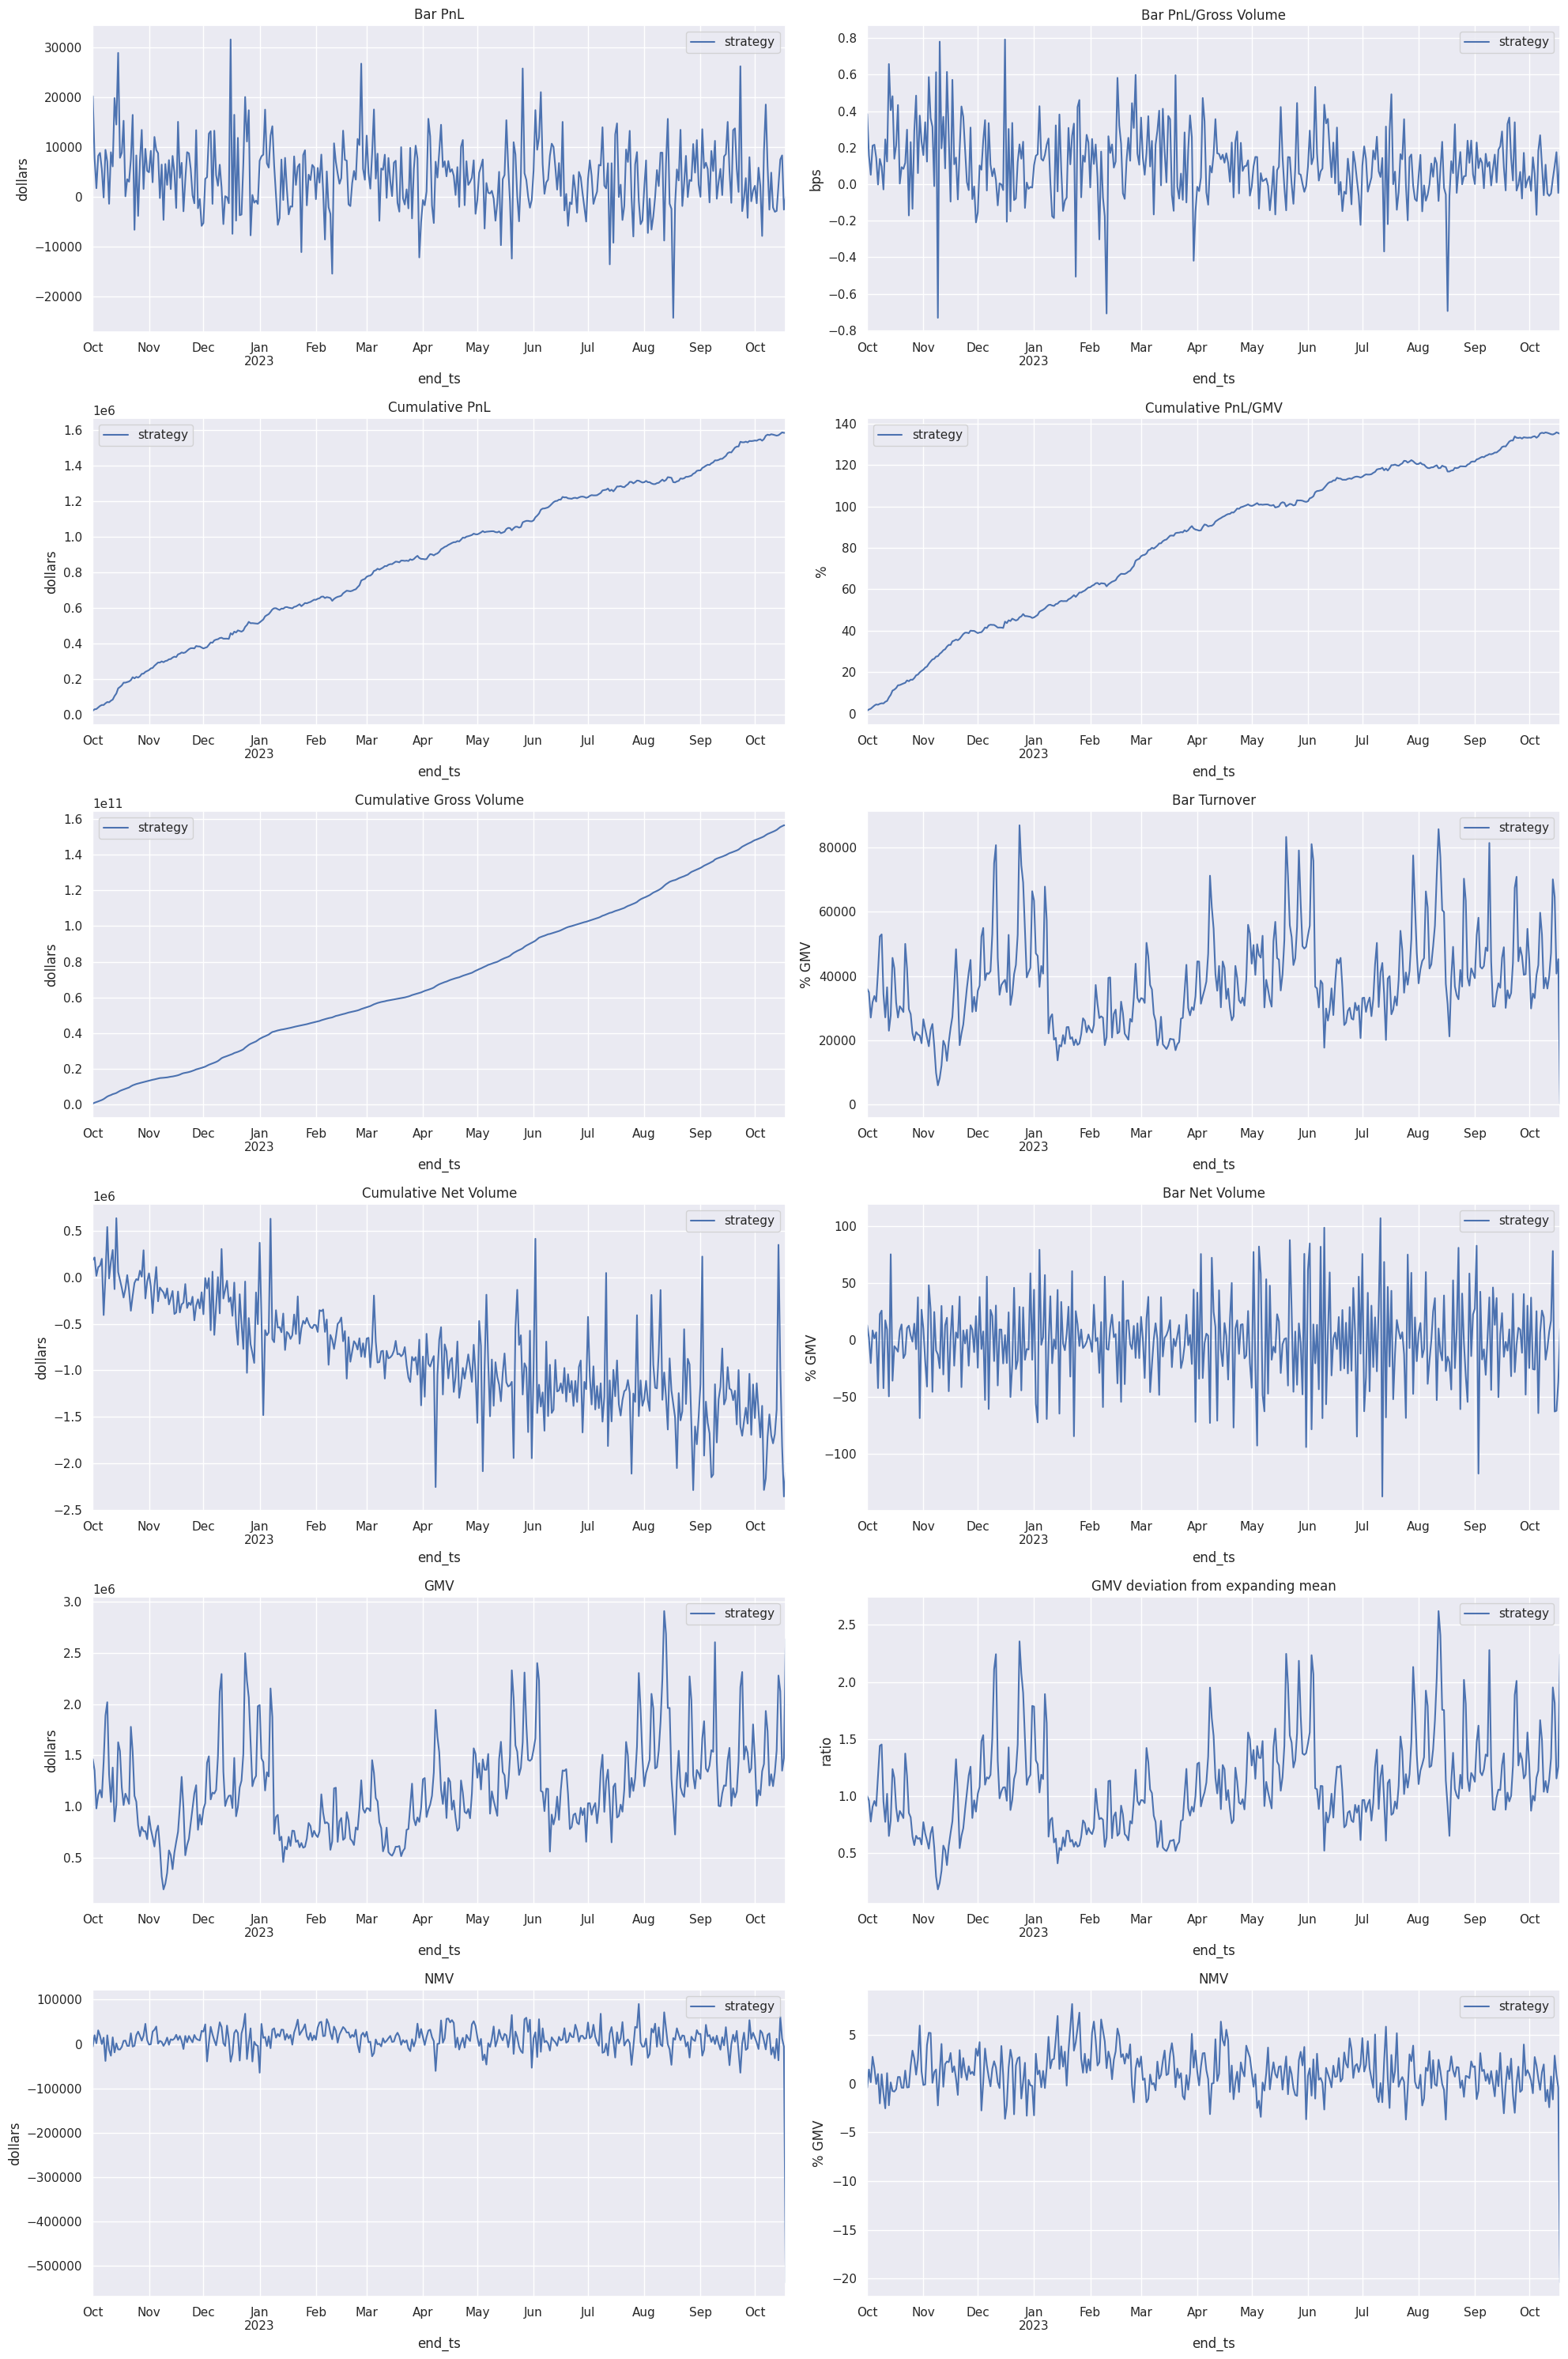

In [19]:
coplotti.plot_portfolio_stats(
    bar_metrics, freq=config["pnl_resampling_frequency"]
)

# Sanity check portfolio

In [20]:
# Check that the PnL is computed correctly by computing it in different ways
# and comparing to the reference one.
# Use the smallest correlation accross instruments to detect an error.
cfpdp.cross_check_portfolio_pnl(portfolio_df).min()

/app/amp/core/finance/portfolio_df_processing/compute_pnl.py:45: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df["holdings_notional"].shift(1).multiply(df["price"].pct_change())


reference_pnl                                   1.0
holdings_notional_diff_minus_trades_notional    1.0
holdings_times_price_diff                       1.0
holdings_notional_minus_trade_times_price       1.0
holdings_notional_times_pct_price_change        1.0
dtype: float64

# Load the asset ids to full symbols mapping

In [21]:
vendor = "CCXT"
mode = "trade"
full_symbols = ivcu.get_vendor_universe(
    vendor, mode, version=config["universe_version"], as_full_symbol=True
)
asset_id_to_full_symbol = ivcu.build_numerical_to_string_id_mapping(full_symbols)
asset_id_to_full_symbol

{6051632686: 'binance::APE_USDT',
 8717633868: 'binance::AVAX_USDT',
 2540896331: 'binance::AXS_USDT',
 1528092593: 'binance::BAKE_USDT',
 8968126878: 'binance::BNB_USDT',
 1467591036: 'binance::BTC_USDT',
 2476706208: 'binance::CRV_USDT',
 5115052901: 'binance::CTK_USDT',
 3065029174: 'binance::DOGE_USDT',
 1891737434: 'binance::DOT_USDT',
 3401245610: 'binance::DYDX_USDT',
 1464553467: 'binance::ETH_USDT',
 1966583502: 'binance::FTM_USDT',
 1030828978: 'binance::GMT_USDT',
 2601760471: 'binance::LINK_USDT',
 2683705052: 'binance::MATIC_USDT',
 9872743573: 'binance::NEAR_USDT',
 2484635488: 'binance::OGN_USDT',
 2099673105: 'binance::RUNE_USDT',
 4516629366: 'binance::SAND_USDT',
 2237530510: 'binance::SOL_USDT',
 2425308589: 'binance::STORJ_USDT',
 1776791608: 'binance::UNFI_USDT',
 2384892553: 'binance::WAVES_USDT',
 5118394986: 'binance::XRP_USDT'}

# Sanity check PnL vs target positions

In [22]:
vendor = "CCXT"
mode = "trade"
# Get asset ids.
asset_ids = ivcu.get_vendor_universe_as_asset_ids(
    config["universe_version"], vendor, mode
)
# Get prod `MarketData`.
db_stage = "preprod"
market_data = dtfamsysc.get_Cx_RealTimeMarketData_prod_instance1(
    asset_ids, db_stage
)
# Load and resample OHLCV data.
start_timestamp = portfolio_df.index.min()
end_timestamp = portfolio_df.index.max()
_LOG.info(
    "start_timestamp=%s, end_timestamp=%s",
    start_timestamp,
    end_timestamp,
)
bar_duration = "5T"
ohlcv_df = dtfamsysc.load_and_resample_ohlcv_data(
    market_data,
    start_timestamp,
    end_timestamp,
    bar_duration,
)
# Convert to UTC to match the timezone from the research portfolio.
ohlcv_df.index = ohlcv_df.index.tz_convert("UTC")
ohlcv_df.tail(3)

INFO  Unable to fetch DB credentials from environment variables: 
	'POSTGRES_HOST'
	Attempting env file method.
INFO  Unable to fetch DB credentials from env file: 
	
################################################################################
* Failed assertion *
'preprod' in '['local', 'dev', 'prod']'
################################################################################

	Attempting AWS SecretsManager method.
INFO  Fetching secret: preprod.im_data_db
INFO  Created preprod DB connection: 
 None


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


INFO  start_timestamp=2022-10-01 00:00:00+00:00, end_timestamp=2023-10-18 00:00:00+00:00
INFO  fit_intervals=[(Timestamp('2022-10-01 00:00:00+0000', tz='UTC'), Timestamp('2023-10-18 00:00:00+0000', tz='UTC'))]


close                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                      \
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488   
end_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2023-10-17 23:50:00+00:00     0.1425    1562.88    28387.0     0.1328      6.104      3.669     0.1772      1.534     23.915     1.4716     0.3813      0.432     0.1150      4.218      7.327     0.5187    0.05902      1.820     0.2869     0.4148     0.4912      1.089      9.104     211.61      1.006     0.1429    1563.90    28404.1     0.1333      6.124      3.671     0.1775      1.536     23.948     1.4722     0.3824      0.433     0.1153      4.219      7.332     0.5189    0.05906      1.823     0.2872     0.4148     0.4912      1.091      9.114     211.68      1.010     0.1425    1561.36    28371.3     0.1327      6.104      3.667     0.1772      1.533     23.901     1.4701     0.3812      0.431     0.1150      4.213      7.322     0.5183    0.05898      1.818     0.2868     0.4144     0.4910      1.088      9.099     211.48      1.006     0.1428    1563.47    28401.1     0.1332      6.121      3.671     0.1774      1.536     23.932     1.4722     0.3823      0.432     0.1153   
2023-10-17 23:55:00+00:00     0.1428    156

In [23]:
# Make sure that the prices from the real-time databases match the ones
# from the research portfolio.
# TODO(Grisha): eventually understand why the correlation is not perfect,
# probably due to prices updates after the fact.
ohlcv_df["vwap"].diff().corrwith(portfolio_df["price"].diff())

1030828978    0.999842
1464553467    0.997978
1467591036    0.999829
1528092593    0.999548
1776791608    0.999840
1891737434    0.999837
1966583502    0.999774
2099673105    0.999416
2237530510    0.999413
2384892553    0.999349
2425308589    0.999754
2476706208    0.999712
2484635488    0.999887
2540896331    0.999845
2601760471    0.999730
2683705052    0.999823
3065029174    0.999840
3401245610    0.999658
4516629366    0.999938
5115052901    0.999733
5118394986    0.999934
6051632686    0.999918
8717633868    0.999811
8968126878    0.999699
9872743573    0.999559
dtype: float64

In [24]:
# Re-compute the PnL using prices from the DB. For some reason the DB data
# starts at `2022-01-08 19:05:00-05:00` and there are small differences between
# the prices used to compute the Portfolio (Parquet data) vs the DB prices.
holdings_shares = portfolio_df["holdings_shares"].loc[
    "2022-01-08 19:05:00-05:00":
]
new_pnl = holdings_shares.shift(1).multiply(ohlcv_df["vwap"].diff())
# Check that the re-computed PnL matches the one from the research Portfolio.
new_pnl.corrwith(portfolio_df["pnl"].loc["2022-01-08 19:05:00-05:00":])

asset_id
1030828978    0.999785
1464553467    0.999778
1467591036    0.999881
1528092593    0.999833
1776791608    0.999838
1891737434    0.999832
1966583502    0.999823
2099673105    0.999602
2237530510    0.999696
2384892553    0.999766
2425308589    0.999705
2476706208    0.999783
2484635488    0.999877
2540896331    0.999854
2601760471    0.999762
2683705052    0.999905
3065029174    0.999746
3401245610    0.999705
4516629366    0.999929
5115052901    0.999653
5118394986    0.999821
6051632686    0.999936
8717633868    0.999936
8968126878    0.999784
9872743573    0.999763
dtype: float64

# Save data

In [25]:
# Create directory to save analysis results.
incremental = True
hio.create_dir(config["save_data_dst_dir"], incremental)

In [26]:
idx_name = portfolio_df.index.name
idx_name

'end_ts'

## Target holdings shares

In [27]:
# Get target holdings shares and prices.
target_holdings_shares = portfolio_df[["holdings_shares"]].shift(-1)
price = portfolio_df[["price"]]
target_holdings_shares_df = pd.concat([target_holdings_shares, price], axis=1)
# Map asset ids to full symbols.
target_holdings_shares_df = target_holdings_shares_df.stack().reset_index()
target_holdings_shares_df["full_symbol"] = target_holdings_shares_df[
    "asset_id"
].apply(lambda x: asset_id_to_full_symbol[x])
# Keep only the relevant columns.
target_holdings_shares_df = target_holdings_shares_df.rename(
    columns={"holdings_shares": "target_holdings_shares"}
)
target_holdings_shares_df = target_holdings_shares_df[
    [idx_name, "full_symbol", "target_holdings_shares", "price"]
]
#
_LOG.info("df.shape=%s", target_holdings_shares_df.shape)
target_holdings_shares_df.tail(10)

INFO  df.shape=(2750375, 4)


,end_ts,full_symbol,target_holdings_shares,price
2750365,2023-10-18 00:00:00+00:00,binance::MATIC_USDT,NaN,0.518939
2750366,2023-10-18 00:00:00+00:00,binance::DOGE_USDT,NaN,0.058998
2750367,2023-10-18 00:00:00+00:00,binance::DYDX_USDT,NaN,1.819888
2750368,2023-10-18 00:00:00+00:00,binance::SAND_USDT,NaN,0.286597
2750369,2023-10-18 00:00:00+00:00,binance::CTK_USDT,NaN,0.415439
2750370,2023-10-18 00:00:00+00:00,binance::XRP_USDT,NaN,0.491209
2750371,2023-10-18 00:00:00+00:00,binance::APE_USDT,NaN,1.089922
2750372,2023-10-18 00:00:00+00:00,binance::AVAX_USDT,NaN,9.104643
2750373,2023-10-18 00:00:00+00:00,binance::BNB_USDT,NaN,211.678318
2750374,2023-10-18 00:00:00+00:00,binance::NEAR_USDT,NaN,1.007388


## PnL

In [28]:
pnl_df = portfolio_df["pnl"].stack().reset_index()
# Mapp asset ids to fulls symbols.
pnl_df["full_symbol"] = pnl_df["asset_id"].apply(
    lambda x: asset_id_to_full_symbol[x]
)
# Rename.
pnl_df = pnl_df.rename(columns={0: "pnl"})
# Keep only the relevant columns.
pnl_df = pnl_df[["end_ts", "full_symbol", "pnl"]]
_LOG.info("df.shape=%s", pnl_df.shape)
pnl_df.tail(10)

INFO  df.shape=(2750200, 3)


,end_ts,full_symbol,pnl
2750190,2023-10-18 00:00:00+00:00,binance::MATIC_USDT,-21.050671
2750191,2023-10-18 00:00:00+00:00,binance::DOGE_USDT,26.781309
2750192,2023-10-18 00:00:00+00:00,binance::DYDX_USDT,-4.544738
2750193,2023-10-18 00:00:00+00:00,binance::SAND_USDT,94.598956
2750194,2023-10-18 00:00:00+00:00,binance::CTK_USDT,-37.225244
2750195,2023-10-18 00:00:00+00:00,binance::XRP_USDT,40.503285
2750196,2023-10-18 00:00:00+00:00,binance::APE_USDT,-5.518191
2750197,2023-10-18 00:00:00+00:00,binance::AVAX_USDT,0.132212
2750198,2023-10-18 00:00:00+00:00,binance::BNB_USDT,8.435998
2750199,2023-10-18 00:00:00+00:00,binance::NEAR_USDT,9.127225


## Compare research PnL with the PnL reconstructed from target holdings and prices

In [29]:
target_holdings_pivot = target_holdings_shares_df.pivot(
    index="end_ts", columns="full_symbol"
)
target_holdings_pivot.tail(3)

target_holdings_shares                                                                                                                                                                                                                                                                                                                                                                                                                                                                            price                                                                                                                                                                                                                                                                                                                                                                                                                                                               
full_symbol                    binance::APE_USDT binance::AVAX_USDT binance::AXS_USDT binance::BAKE_USDT binance::BNB_USDT binance::BTC_USDT binance::CRV_USDT binance::CTK_USDT binance::DOGE_USDT binance::DOT_USDT binance::DYDX_USDT binance::ETH_USDT binance::FTM_USDT binance::GMT_USDT binance::LINK_USDT binance::MATIC_USDT binance::NEAR_USDT binance::OGN_USDT binance::RUNE_USDT binance::SAND_USDT binance::SOL_USDT binance::STORJ_USDT binance::UNFI_USDT binance::WAVES_USDT binance::XRP_USDT binance::APE_USDT binance::AVAX_USDT binance::AXS_USDT binance::BAKE_USDT binance::BNB_USDT binance::BTC_USDT binance::CRV_USDT binance::CTK_USDT binance::DOGE_USDT binance::DOT_USDT binance::DYDX_USDT binance::ETH_USDT binance::FTM_USDT binance::GMT_USDT binance::LINK_USDT binance::MATIC_USDT binance::NEAR_USDT binance::OGN_USDT binance::RUNE_USDT binance::SAND_USDT binance::SOL_USDT binance::STORJ_USDT binance::UNFI_USDT binance::WAVES_USDT binance::XRP_USDT
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2023-10-17 23:50:00+00:00               -29091.0            -5817.0          -11787.0           145536.0           -356.71             2.329           35355.3         -196786.0          -984229.0           19683.0           -14370.5            28.446          291091.0          235248.0           -7872.84           -123265.0            23532.0         -494304.0           -29088.0          -235116.0           -1586.0             86638.0            -5324.3            -34779.2         -741348.3          1.089100           9.105905          4.215317           0.132909        211.551733      28383.581679          0.432000          0.414609           0.059002          3.668218           1.819909       1562.176718          0.177244          0.142644           7.325665            0.518564           1.007414          0.115140           1.534217           0.286934         23.929430            0.381433           6.109897            1.471413          0.491130
2023-10-17 23:55:00+00:00                24647.0            14366.0          -49422.0           353375.0           -768.08            -8.063         -148217.8          -83565.0      

In [30]:
pnl_pivot = pnl_df.pivot(index="end_ts", columns="full_symbol")
pnl_pivot.tail(3)

pnl                                                                                                                                                                                                                                                                                                                                                                                                                                                               
full_symbol               binance::APE_USDT binance::AVAX_USDT binance::AXS_USDT binance::BAKE_USDT binance::BNB_USDT binance::BTC_USDT binance::CRV_USDT binance::CTK_USDT binance::DOGE_USDT binance::DOT_USDT binance::DYDX_USDT binance::ETH_USDT binance::FTM_USDT binance::GMT_USDT binance::LINK_USDT binance::MATIC_USDT binance::NEAR_USDT binance::OGN_USDT binance::RUNE_USDT binance::SAND_USDT binance::SOL_USDT binance::STORJ_USDT binance::UNFI_USDT binance::WAVES_USDT binance::XRP_USDT
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
2023-10-17 23:50:00+00:00        -16.797621          60.014563         41.175482         233.187948         63.701630         95.492029        152.497022        -42.436763         -72.889787        -92.346160          51.527421         79.344924        259.851435        101.937972         -53.305063          -15.163269         232.341175         58.236999          51.159177          44.627805        -53.720711           93.124711         -53.761568          -33.033168         -8.101018
2023-10-17 23:55:00+00:00         14.926552          17.517011       -112.249902         -29.901810        -84.880928         21.150080         23.960813         84.120656         -54.056723        -77.753555          11.930846        110.652888          4.034049         20.178476          17.815369           30.933466          30.684812         55.196882         -20.398927          23.193838         14.486391           -3.601794         -18.183518           12.623236        -24.220249
2023-10-18 00:00:00+00:00         -5.518191           0.132212          2.374993         -19.270941          8.435998         -2.718058         10.020550        -37.225244          26.781309        -21.826653          -4.544738          8.511153        -52.578677         22.098813          72.242725          -21.050671           9.127225         71.499252         -35.172835          94.598956         14.266828           15.680980          10.228925         -163.606175         40.503285

In [31]:
# Recompute the PnL using `target_holdings_shares` and prices.
reconstructed_pnl = (
    target_holdings_pivot["target_holdings_shares"]
    .shift(2)
    .multiply(target_holdings_pivot["price"].diff())
)
reconstructed_pnl.tail(3)

full_symbol,binance::APE_USDT,binance::AVAX_USDT,binance::AXS_USDT,binance::BAKE_USDT,binance::BNB_USDT,binance::BTC_USDT,binance::CRV_USDT,binance::CTK_USDT,binance::DOGE_USDT,binance::DOT_USDT,binance::DYDX_USDT,binance::ETH_USDT,binance::FTM_USDT,binance::GMT_USDT,binance::LINK_USDT,binance::MATIC_USDT,binance::NEAR_USDT,binance::OGN_USDT,binance::RUNE_USDT,binance::SAND_USDT,binance::SOL_USDT,binance::STORJ_USDT,binance::UNFI_USDT,binance::WAVES_USDT,binance::XRP_USDT
end_ts,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-17 23:50:00+00:00,-16.797621,60.014563,41.175482,233.187948,63.701630,95.492029,152.497022,-42.436763,-72.889787,-92.346160,51.527421,79.344924,259.851435,101.937972,-53.305063,-15.163269,232.341175,58.236999,51.159177,44.627805,-53.720711,93.124711,-53.761568,-33.033168,-8.101018
2023-10-17 23:55:00+00:00,14.926552,17.517011,-112.249902,-29.901810,-84.880928,21.150080,23.960813,84.120656,-54.056723,-77.753555,11.930846,110.652888,4.034049,20.178476,17.815369,30.933466,30.684812,55.196882,-20.398927,23.193838,14.486391,-3.601794,-18.183518,12.623236,-24.220249
2023-10-18 00:00:00+00:00,-5.518191,0.132212,2.374993,-19.270941,8.435998,-2.718058,10.020550,-37.225244,26.781309,-21.826653,-4.544738,8.511153,-52.578677,22.098813,72.242725,-21.050671,9.127225,71.499252,-35.172835,94.598956,14.266828,15.680980,10.228925,-163.606175,40.503285


In [32]:
# The correlation coefficient must be close to 1.
pnl_pivot["pnl"].corrwith(reconstructed_pnl)

full_symbol
binance::APE_USDT      1.0
binance::AVAX_USDT     1.0
binance::AXS_USDT      1.0
binance::BAKE_USDT     1.0
binance::BNB_USDT      1.0
binance::BTC_USDT      1.0
binance::CRV_USDT      1.0
binance::CTK_USDT      1.0
binance::DOGE_USDT     1.0
binance::DOT_USDT      1.0
binance::DYDX_USDT     1.0
binance::ETH_USDT      1.0
binance::FTM_USDT      1.0
binance::GMT_USDT      1.0
binance::LINK_USDT     1.0
binance::MATIC_USDT    1.0
binance::NEAR_USDT     1.0
binance::OGN_USDT      1.0
binance::RUNE_USDT     1.0
binance::SAND_USDT     1.0
binance::SOL_USDT      1.0
binance::STORJ_USDT    1.0
binance::UNFI_USDT     1.0
binance::WAVES_USDT    1.0
binance::XRP_USDT      1.0
dtype: float64

## Save data to the disk

In [33]:
# TODO(Grisha): factor out the piece that saves a file.
if config["save_data"]:
    target_holdings_shares_path = os.path.join(
        config["save_data_dst_dir"], "target_holdings_shares_and_prices.csv.gz"
    )
    target_holdings_shares_df.to_csv(target_holdings_shares_path, index=False)
    tmp = pd.read_csv(target_holdings_shares_path)
    _LOG.info("df.shape=%s", tmp.shape)
    tmp.tail(10)

INFO  df.shape=(2750375, 4)


In [34]:
if config["save_data"]:
    # 1) Save the original PnL.
    pnl_path = os.path.join(config["save_data_dst_dir"], "pnl.bar_by_bar.csv.gz")
    pnl_pivot.stack().reset_index().to_csv(pnl_path, index=False)
    tmp = pd.read_csv(pnl_path)
    _LOG.info("df.shape=%s", tmp.shape)
    tmp.tail(10)
    # 2) Save resampled PnL data.
    pnl_resampled_path = os.path.join(
        config["save_data_dst_dir"], "pnl.daily.csv.gz"
    )
    # Resample PnL to the specified frequency before saving.
    # Summing is a decent approximation for going from intraday to daily returns.
    resampled_pnl = pnl_pivot.resample(config["pnl_resampling_frequency"]).sum()
    resampled_pnl = resampled_pnl.stack().reset_index()
    resampled_pnl.to_csv(pnl_resampled_path, index=False)
    tmp = pd.read_csv(pnl_resampled_path)
    _LOG.info("df.shape=%s", tmp.shape)
    tmp.tail(10)

INFO  df.shape=(2750200, 3)
INFO  df.shape=(9575, 3)
